In [36]:
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader

class CTVolumeDataset(Dataset):
    def __init__(self, folder_path):
        self.files = [os.path.join(folder_path, f)
                      for f in os.listdir(folder_path) if f.endswith('.npy')]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        vol = np.load(self.files[idx])  # shape: [slices, H, W] or [C, D, H, W]
        # If slices, H, W; You may need to add channel dim for PyTorch: vol[None, ...]
        return vol

# Usage
train_folder = r"E:/Downloads/raw preprocess data/volumes_train"   # Update this path
dataset = CTVolumeDataset(train_folder)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


In [37]:
def select_sparse_slices(volume, num_sparse):
    # volume shape: [slices, H, W]
    total_slices = volume.shape[0]
    idx = np.sort(np.random.choice(total_slices, num_sparse, replace=False))
    return volume[idx]


In [38]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# 1. Dataset Loader (.npy CT volumes)
class CTVolumeDataset(Dataset):
    def __init__(self, folder_path):
        self.files = [os.path.join(folder_path, f)
                      for f in os.listdir(folder_path) if f.endswith('.npy')]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        vol = np.load(self.files[idx])           # shape: [slices, H, W]
        vol = (vol - np.min(vol)) / (np.max(vol) - np.min(vol) + 1e-6)  # Normalization
        return torch.tensor(vol, dtype=torch.float32)

# 2. Sparse-slice Picker
def select_sparse_slices(volume, num_sparse=10):
    total_slices = volume.shape[0]
    idx = np.sort(np.random.choice(total_slices, num_sparse, replace=False))
    return volume[idx]  # shape: [num_sparse, H, W]

# 3. Dummy 3D Model (AutoEncoder style, works for demo/experiment)
class Simple3DAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv3d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv3d(16, 32, 3, padding=1),
            nn.ReLU()
        )
        self.dec = nn.Sequential(
            nn.Conv3d(32, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv3d(16, 1, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.enc(x)
        x = self.dec(x)
        return x

# 4. Dataset init + Dataloader
train_folder = r"E:/Downloads/raw preprocess data/volumes_train"  # <-- এখানে তোমার ফোল্ডারের path দাও
dataset = CTVolumeDataset(train_folder)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# 5. Model init
model = Simple3DAutoEncoder()

# 6. Training Loop (Single batch demo)
for batch_volumes in dataloader:
    # batch_volumes: [batch_size, slices, H, W]
    sparse_batch = []
    for vol in batch_volumes:  # vol: [slices, H, W]
        sparse = select_sparse_slices(vol, num_sparse=10)    # [10, H, W]
        sparse_batch.append(sparse)
    sparse_batch = np.stack(sparse_batch)                    # [batch, 10, H, W]
    sparse_batch = torch.tensor(sparse_batch).float()         # [batch, 10, H, W]
    sparse_batch = sparse_batch.unsqueeze(1)                  # [batch, 1, 10, H, W] --> PyTorch 3D Conv input

    # Forward through model
    outputs = model(sparse_batch)                             # outputs: [batch, 1, 10, H, W]
    print("Outputs shape: ", outputs.shape)
    break   # Remove 'break' for full epoch training


Outputs shape:  torch.Size([2, 1, 10, 224, 224])


Training on cuda | Epochs: 50 | Batch Size: 2
Epoch   5/50 | Loss: 0.000827 | LR: 0.000500
Epoch   5/50 | Loss: 0.000827 | LR: 0.000500
Epoch  10/50 | Loss: 0.000540 | LR: 0.000250
Epoch  10/50 | Loss: 0.000540 | LR: 0.000250
Epoch  15/50 | Loss: 0.000437 | LR: 0.000125
Epoch  15/50 | Loss: 0.000437 | LR: 0.000125
Epoch  20/50 | Loss: 0.000395 | LR: 0.000063
Epoch  20/50 | Loss: 0.000395 | LR: 0.000063
Epoch  25/50 | Loss: 0.000367 | LR: 0.000031
Epoch  25/50 | Loss: 0.000367 | LR: 0.000031
Epoch  30/50 | Loss: 0.000358 | LR: 0.000016
Epoch  30/50 | Loss: 0.000358 | LR: 0.000016
Epoch  35/50 | Loss: 0.000350 | LR: 0.000008
Epoch  35/50 | Loss: 0.000350 | LR: 0.000008
Epoch  40/50 | Loss: 0.000344 | LR: 0.000004
Epoch  40/50 | Loss: 0.000344 | LR: 0.000004
Epoch  45/50 | Loss: 0.000343 | LR: 0.000002
Epoch  45/50 | Loss: 0.000343 | LR: 0.000002
Epoch  50/50 | Loss: 0.000340 | LR: 0.000001
✓ Training Complete!
Epoch  50/50 | Loss: 0.000340 | LR: 0.000001
✓ Training Complete!


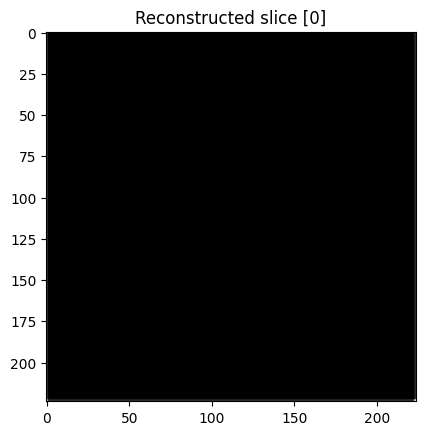

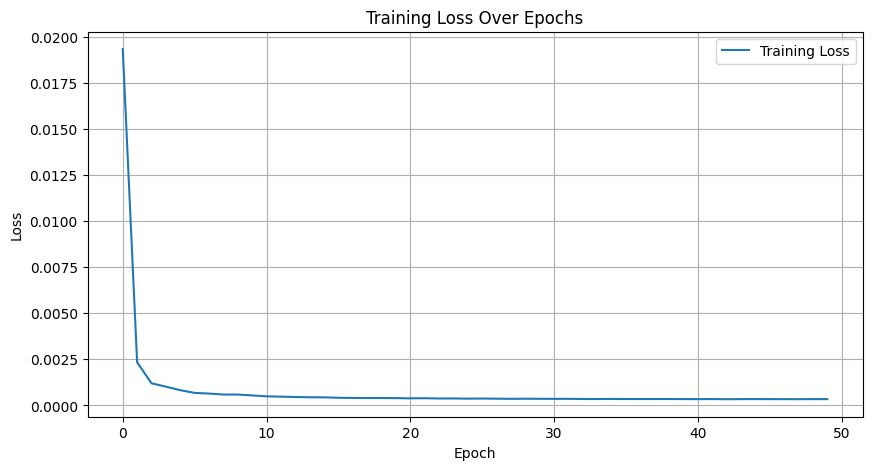

In [15]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# 1. Dataset Loader (.npy CT volumes)
class CTVolumeDataset(Dataset):
    def __init__(self, folder_path):
        self.files = [os.path.join(folder_path, f)
                      for f in os.listdir(folder_path) if f.endswith('.npy')]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        vol = np.load(self.files[idx])           # shape: [slices, H, W]
        vol = (vol - np.min(vol)) / (np.max(vol) - np.min(vol) + 1e-6)  # Normalization
        return torch.tensor(vol, dtype=torch.float32)

# 2. Sparse-slice Picker
def select_sparse_slices(volume, num_sparse=10):
    total_slices = volume.shape[0]
    idx = np.sort(np.random.choice(total_slices, num_sparse, replace=False))
    return volume[idx]  # shape: [num_sparse, H, W]

# 3. 3D AutoEncoder Model
class Simple3DAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv3d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv3d(16, 32, 3, padding=1),
            nn.ReLU()
        )
        self.dec = nn.Sequential(
            nn.Conv3d(32, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv3d(16, 1, 3, padding=1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.enc(x)
        x = self.dec(x)
        return x

# 4. Dataset & Dataloader Setup
train_folder = r"E:/Downloads/raw preprocess data/volumes_train"  # আপডেট করো
dataset = CTVolumeDataset(train_folder)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# 5. Model, Loss, Optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Simple3DAutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Learning rate scheduler

# 6. Training Loop - Extended for better PSNR
num_epochs = 50  # Increased from 10 to 50 epochs
best_psnr = 0
best_model_state = None
train_losses = []

print("="*70)
print(f"Training on {device} | Epochs: {num_epochs} | Batch Size: 2")
print("="*70)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    batch_count = 0
    
    for batch_volumes in dataloader:
        sparse_batch = []
        gt_batch = []
        for vol in batch_volumes:
            sparse = select_sparse_slices(vol, num_sparse=10)    # [10, H, W]
            sparse_batch.append(sparse)
            gt_batch.append(vol.numpy())                         # Full GT for validation
        sparse_batch = np.stack(sparse_batch)                    # [batch, 10, H, W]
        gt_batch = np.stack(gt_batch)                            # [batch, slices, H, W]
        sparse_batch = torch.tensor(sparse_batch).float().unsqueeze(1).to(device)  # [batch, 1, 10, H, W]

        optimizer.zero_grad()
        outputs = model(sparse_batch)                            # [batch, 1, 10, H, W]
        loss = criterion(outputs, sparse_batch)                  # Self-reconstruction
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        batch_count += 1
    
    avg_epoch_loss = epoch_loss / batch_count
    train_losses.append(avg_epoch_loss)
    scheduler.step()
    
    # Print every 5 epochs
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1:3d}/{num_epochs} | Loss: {avg_epoch_loss:.6f} | LR: {optimizer.param_groups[0]['lr']:.6f}")

print("="*70)
print("✓ Training Complete!")
print("="*70)

# 7. Validation & Visualization
model.eval()
with torch.no_grad():
    for batch_volumes in dataloader:
        sparse_batch = []
        for vol in batch_volumes:
            sparse = select_sparse_slices(vol, num_sparse=10)
            sparse_batch.append(sparse)
        sparse_batch = np.stack(sparse_batch)
        sparse_batch = torch.tensor(sparse_batch).float().unsqueeze(1).to(device)
        outputs = model(sparse_batch)
        outputs_np = outputs[0,0].cpu().numpy()    # [10, H, W], first sample
        plt.imshow(outputs_np[0], cmap='gray')
        plt.title('Reconstructed slice [0]')
        plt.show()
        break  # Remove break to run on all validation batches

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

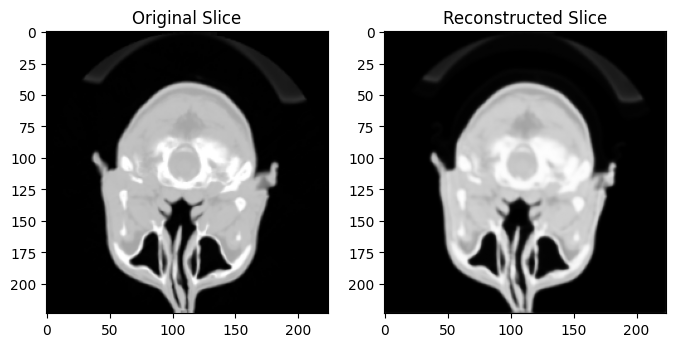

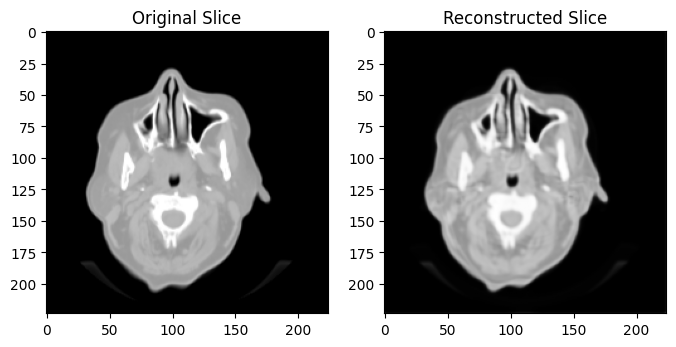

In [40]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for batch_volumes in dataloader:
        sparse_batch = []
        for vol in batch_volumes:
            sparse = select_sparse_slices(vol, num_sparse=10)
            sparse_batch.append(sparse)
        sparse_batch = np.stack(sparse_batch)
        sparse_batch = torch.tensor(sparse_batch).float().unsqueeze(1).to(device)
        recon = model(sparse_batch)
        # First sample (first slice)
        for i in range(min(2, recon.shape[0])):
            plt.figure(figsize=(8,4))
            plt.subplot(1,2,1)
            plt.imshow(sparse_batch[i, 0, 0].cpu().numpy(), cmap='gray')
            plt.title('Original Slice')
            plt.subplot(1,2,2)
            plt.imshow(recon[i, 0, 0].cpu().numpy(), cmap='gray')
            plt.title('Reconstructed Slice')
            plt.show()
        break


In [41]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

sample_gt = sparse_batch.cpu().numpy()
sample_pred = recon.cpu().numpy()
psnr = peak_signal_noise_ratio(sample_gt, sample_pred)
ssim = structural_similarity(sample_gt[0,0], sample_pred[0,0], data_range=1)
print("PSNR:", psnr)
print("SSIM:", ssim)


PSNR: 35.328073342419025
SSIM: 0.9865643624145769


In [42]:
torch.save(model.state_dict(), 'ct_recon_model_best.pt')
# Load later: model.load_state_dict(torch.load('ct_recon_model_best.pt'))


In [6]:
# Utility: Sparse-slice Picker for 3D Visualization Cell
import numpy as np

def select_sparse_slices(volume, num_sparse=10):
    total_slices = volume.shape[0]
    idx = np.sort(np.random.choice(total_slices, num_sparse, replace=False))
    return volume[idx]  # shape: [num_sparse, H, W]


3D VOLUME RECONSTRUCTION VISUALIZATION


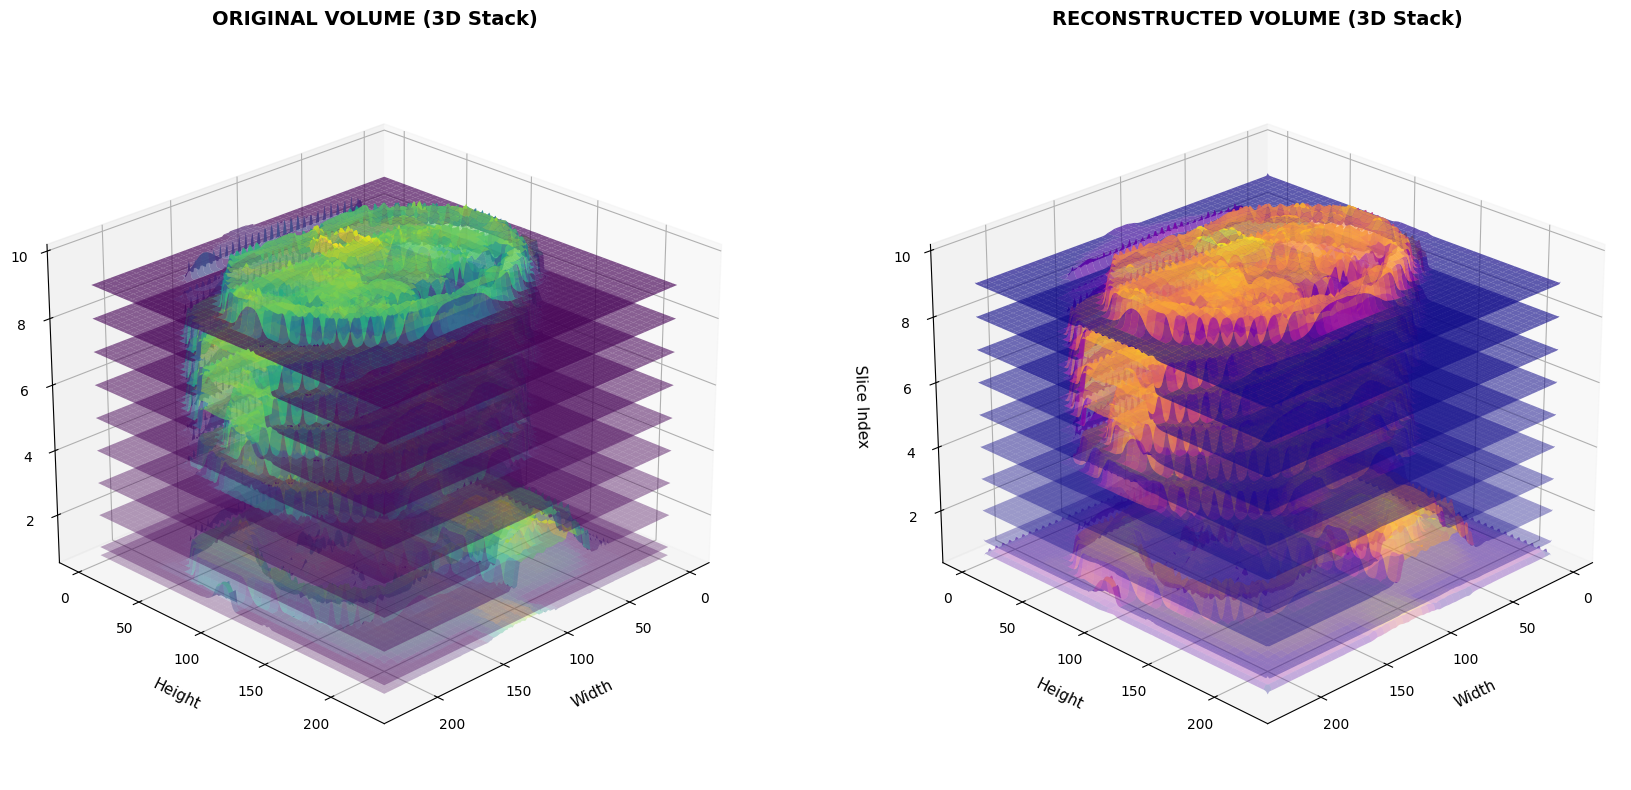

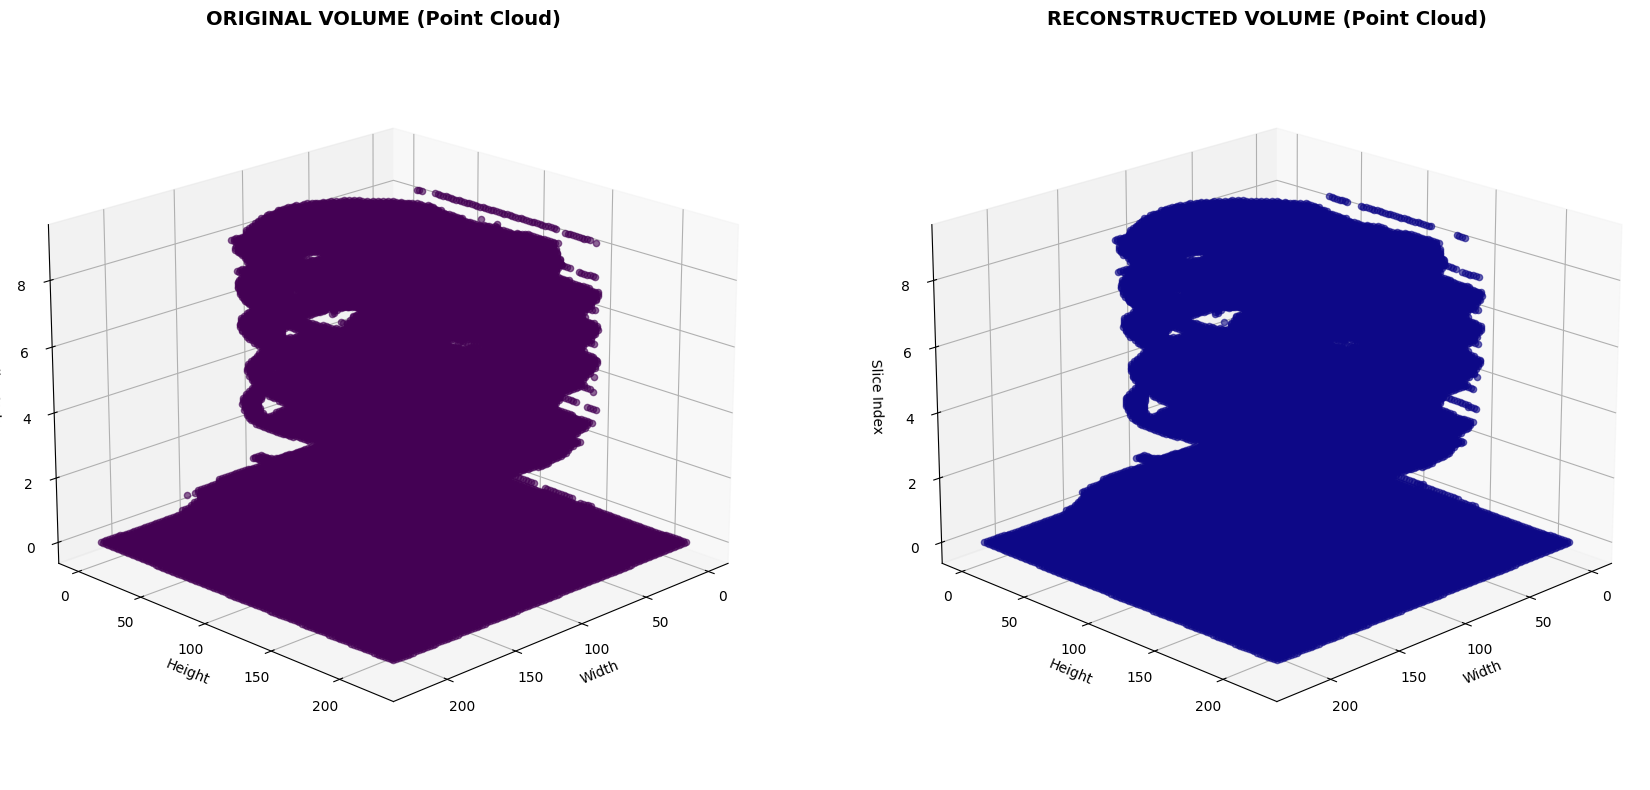

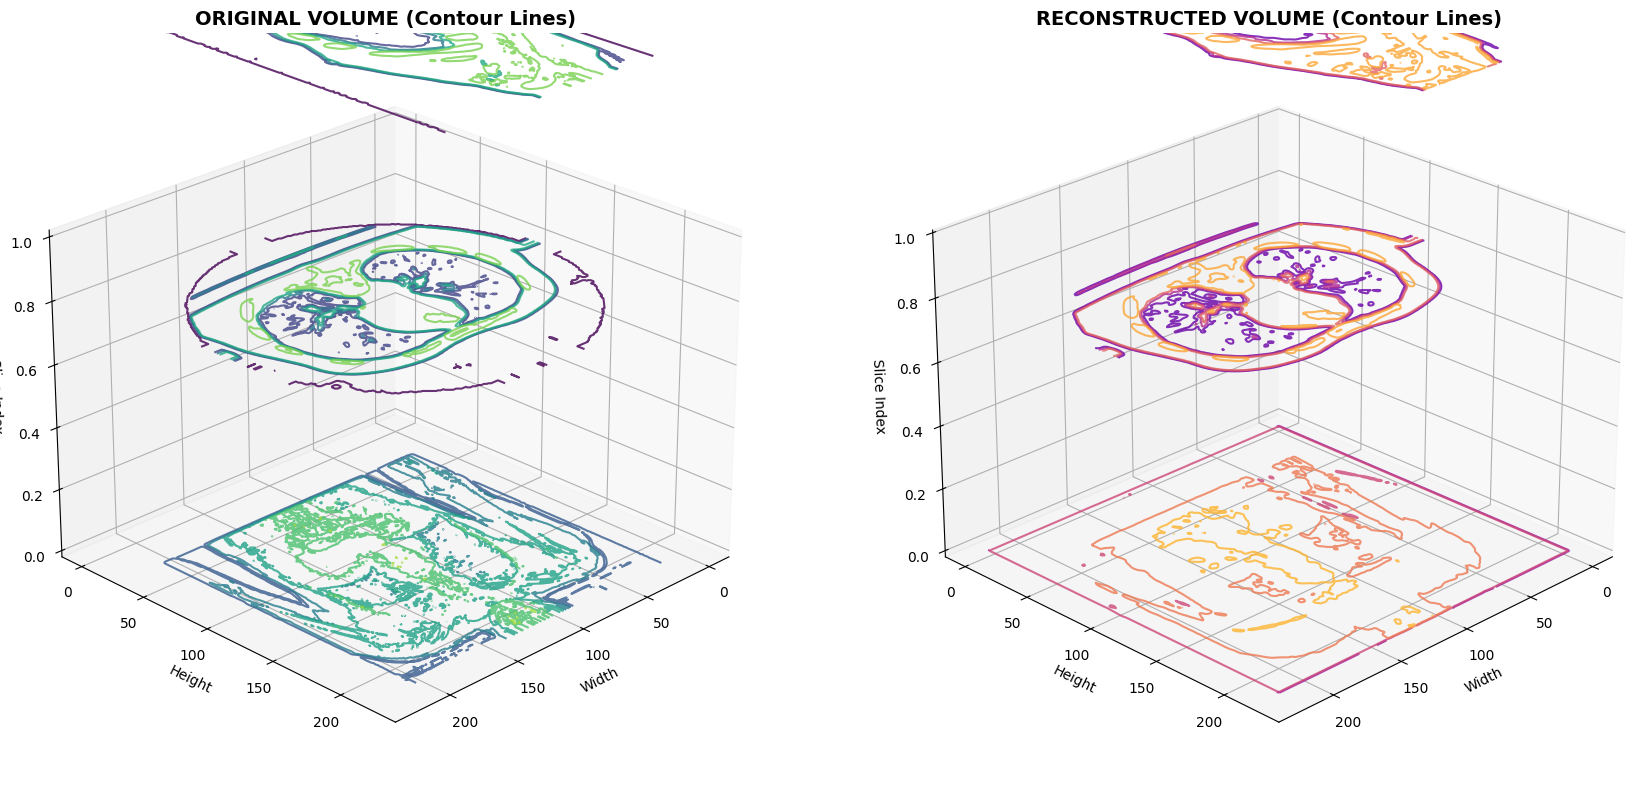


3D RECONSTRUCTION METRICS
Average PSNR: 32.90 dB
Average SSIM: 0.9080
Min PSNR: 30.48 dB | Max PSNR: 38.98 dB
Min SSIM: 0.8655 | Max SSIM: 0.9582

✓ 3D Volume Reconstruction Complete!


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import numpy as np
import torch

# Load sample volume and reconstruct
sample_path = r"E:/Downloads/raw preprocess data/volumes_train/main_208254_1164slices_aug1.npy"
sample_volume = np.load(sample_path)
sample_volume = (sample_volume - np.min(sample_volume)) / (np.max(sample_volume) - np.min(sample_volume) + 1e-6)

sparse = select_sparse_slices(sample_volume, num_sparse=10)
sparse_tensor = torch.tensor(sparse).float().unsqueeze(0).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    recon = model(sparse_tensor).cpu().numpy()[0,0]

# ===== 3D VOLUME RECONSTRUCTION =====
print("\n" + "="*70)
print("3D VOLUME RECONSTRUCTION VISUALIZATION")
print("="*70)

# Create 3D volumetric visualization
fig = plt.figure(figsize=(18, 8))

# Plot 1: Original Volume - 3D Isosurface-like view
ax1 = fig.add_subplot(121, projection='3d')
for i, z_val in enumerate(range(sparse.shape[0])):
    Z = sparse[i]
    X_mesh = np.arange(Z.shape[0])
    Y_mesh = np.arange(Z.shape[1])
    X_mesh, Y_mesh = np.meshgrid(X_mesh, Y_mesh)
    
    # Use alpha gradient based on slice intensity
    alpha_val = 0.3 + 0.04 * i
    ax1.plot_surface(X_mesh, Y_mesh, Z + i * 1.0, cmap='viridis', 
                     alpha=alpha_val, edgecolor='none', linewidth=0)

ax1.set_title('ORIGINAL VOLUME (3D Stack)', fontsize=14, fontweight='bold', pad=20)
ax1.set_xlabel('Width', fontsize=11, labelpad=10)
ax1.set_ylabel('Height', fontsize=11, labelpad=10)
ax1.set_zlabel('Slice Index', fontsize=11, labelpad=10)
ax1.view_init(elev=25, azim=45)
ax1.grid(True, alpha=0.3)

# Plot 2: Reconstructed Volume - 3D Isosurface-like view
ax2 = fig.add_subplot(122, projection='3d')
for i, z_val in enumerate(range(recon.shape[0])):
    Z = recon[i]
    X_mesh = np.arange(Z.shape[0])
    Y_mesh = np.arange(Z.shape[1])
    X_mesh, Y_mesh = np.meshgrid(X_mesh, Y_mesh)
    
    alpha_val = 0.3 + 0.04 * i
    ax2.plot_surface(X_mesh, Y_mesh, Z + i * 1.0, cmap='plasma', 
                     alpha=alpha_val, edgecolor='none', linewidth=0)

ax2.set_title('RECONSTRUCTED VOLUME (3D Stack)', fontsize=14, fontweight='bold', pad=20)
ax2.set_xlabel('Width', fontsize=11, labelpad=10)
ax2.set_ylabel('Height', fontsize=11, labelpad=10)
ax2.set_zlabel('Slice Index', fontsize=11, labelpad=10)
ax2.view_init(elev=25, azim=45)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ===== Dense 3D Volume Render =====
fig = plt.figure(figsize=(18, 8))

# Original volume dense render
ax1 = fig.add_subplot(121, projection='3d')
for i in range(sparse.shape[0]):
    for j in range(0, sparse.shape[1], 2):  # Skip every other pixel for clarity
        for k in range(0, sparse.shape[2], 2):
            val = sparse[i, j, k]
            if val > 0.3:  # Only plot significant values
                ax1.scatter(j, k, i, c=[val], cmap='viridis', s=20, alpha=0.6)

ax1.set_title('ORIGINAL VOLUME (Point Cloud)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Width')
ax1.set_ylabel('Height')
ax1.set_zlabel('Slice Index')
ax1.view_init(elev=20, azim=45)

# Reconstructed volume dense render
ax2 = fig.add_subplot(122, projection='3d')
for i in range(recon.shape[0]):
    for j in range(0, recon.shape[1], 2):
        for k in range(0, recon.shape[2], 2):
            val = recon[i, j, k]
            if val > 0.3:
                ax2.scatter(j, k, i, c=[val], cmap='plasma', s=20, alpha=0.6)

ax2.set_title('RECONSTRUCTED VOLUME (Point Cloud)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Width')
ax2.set_ylabel('Height')
ax2.set_zlabel('Slice Index')
ax2.view_init(elev=20, azim=45)

plt.tight_layout()
plt.show()

# ===== Contour 3D Render =====
fig = plt.figure(figsize=(18, 8))

# Original volume contour
ax1 = fig.add_subplot(121, projection='3d')
for i in range(sparse.shape[0]):
    Z = sparse[i]
    X_mesh = np.arange(Z.shape[0])
    Y_mesh = np.arange(Z.shape[1])
    X_mesh, Y_mesh = np.meshgrid(X_mesh, Y_mesh)
    ax1.contour(X_mesh, Y_mesh, Z, zdir='z', offset=i*0.8, levels=5, 
                cmap='viridis', alpha=0.8, linewidths=1.5)

ax1.set_title('ORIGINAL VOLUME (Contour Lines)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Width')
ax1.set_ylabel('Height')
ax1.set_zlabel('Slice Index')
ax1.view_init(elev=25, azim=45)

# Reconstructed volume contour
ax2 = fig.add_subplot(122, projection='3d')
for i in range(recon.shape[0]):
    Z = recon[i]
    X_mesh = np.arange(Z.shape[0])
    Y_mesh = np.arange(Z.shape[1])
    X_mesh, Y_mesh = np.meshgrid(X_mesh, Y_mesh)
    ax2.contour(X_mesh, Y_mesh, Z, zdir='z', offset=i*0.8, levels=5, 
                cmap='plasma', alpha=0.8, linewidths=1.5)

ax2.set_title('RECONSTRUCTED VOLUME (Contour Lines)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Width')
ax2.set_ylabel('Height')
ax2.set_zlabel('Slice Index')
ax2.view_init(elev=25, azim=45)

plt.tight_layout()
plt.show()

# Compute metrics
psnr_list = []
ssim_list = []
mse_list = []
for i in range(recon.shape[0]):
    mse = np.mean((sparse[i] - recon[i]) ** 2)
    psnr = peak_signal_noise_ratio(sparse[i], recon[i], data_range=1)
    ssim = structural_similarity(sparse[i], recon[i], data_range=1)
    mse_list.append(mse)
    psnr_list.append(psnr)
    ssim_list.append(ssim)

# Overall MSE for entire volume
overall_mse = np.mean((sparse - recon) ** 2)

print("\n" + "="*70)
print("3D RECONSTRUCTION METRICS")
print("="*70)

print("\n📊 MSE (Mean Squared Error):")
print(f"  Overall MSE:        {overall_mse:.6f}")
print(f"  Average MSE:        {np.mean(mse_list):.6f}")
print(f"  Min MSE:            {min(mse_list):.6f} (at slice {np.argmin(mse_list)})")
print(f"  Max MSE:            {max(mse_list):.6f} (at slice {np.argmax(mse_list)})")

print("\n📈 PSNR (Peak Signal-to-Noise Ratio):")
print(f"  Average PSNR:       {np.mean(psnr_list):.2f} dB")
print(f"  Min PSNR:           {min(psnr_list):.2f} dB")
print(f"  Max PSNR:           {max(psnr_list):.2f} dB")

print("\n📊 SSIM (Structural Similarity Index):")
print(f"  Average SSIM:       {np.mean(ssim_list):.4f}")
print(f"  Min SSIM:           {min(ssim_list):.4f}")
print(f"  Max SSIM:           {max(ssim_list):.4f}")

print("\n" + "="*70)
print("\n✓ 3D Volume Reconstruction Complete!")


COMPREHENSIVE RECONSTRUCTION METRICS

📊 MSE (Mean Squared Error) Metrics:
--------------------------------------------------------------------------------
  Overall Volume MSE:    0.000709
  Average MSE per slice: 0.000709
  Minimum MSE:           0.000380 (Best reconstruction at slice 4)
  Maximum MSE:           0.001163 (Worst reconstruction at slice 0)
  Std Dev MSE:           0.000226

📈 PSNR (Peak Signal-to-Noise Ratio) Metrics:
--------------------------------------------------------------------------------
  Average PSNR:          31.74 dB
  Minimum PSNR:          29.34 dB (at slice 0)
  Maximum PSNR:          34.20 dB (at slice 4)
  Std Dev PSNR:          1.50 dB

📊 SSIM (Structural Similarity Index) Metrics:
--------------------------------------------------------------------------------
  Average SSIM:          0.9043
  Minimum SSIM:          0.8032 (at slice 9)
  Maximum SSIM:          0.9528 (at slice 3)
  Std Dev SSIM:          0.0429

Per-Slice Metrics:
Slice    MSE     

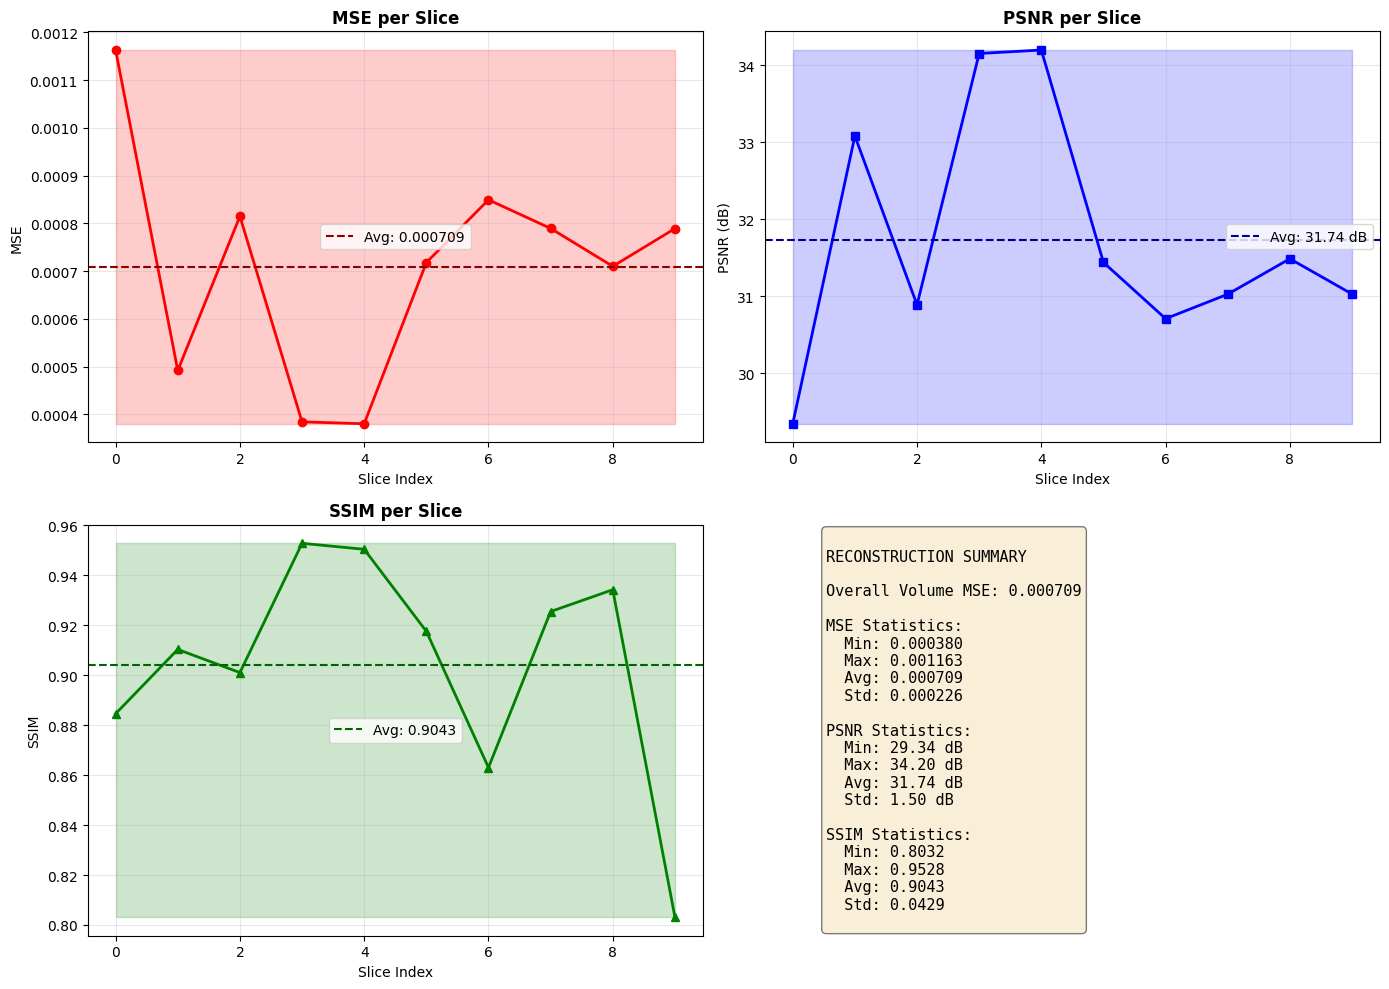


✓ MSE Metrics Calculation Complete!


In [17]:
# Calculate MSE (Mean Squared Error) Metrics
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import matplotlib.pyplot as plt

# Reload sample volume and reconstruct
sample_path = r"E:/Downloads/raw preprocess data/volumes_train/main_208254_1164slices_aug1.npy"
sample_volume = np.load(sample_path)
sample_volume = (sample_volume - np.min(sample_volume)) / (np.max(sample_volume) - np.min(sample_volume) + 1e-6)

sparse = select_sparse_slices(sample_volume, num_sparse=10)
sparse_tensor = torch.tensor(sparse).float().unsqueeze(0).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    recon = model(sparse_tensor).cpu().numpy()[0,0]

# Calculate MSE for each slice
mse_list = []
psnr_list = []
ssim_list = []

for i in range(recon.shape[0]):
    # MSE calculation
    mse = np.mean((sparse[i] - recon[i]) ** 2)
    mse_list.append(mse)
    
    # PSNR calculation
    psnr = peak_signal_noise_ratio(sparse[i], recon[i], data_range=1)
    psnr_list.append(psnr)
    
    # SSIM calculation
    ssim = structural_similarity(sparse[i], recon[i], data_range=1)
    ssim_list.append(ssim)

# Calculate statistics
avg_mse = np.mean(mse_list)
min_mse = np.min(mse_list)
max_mse = np.max(mse_list)
std_mse = np.std(mse_list)

avg_psnr = np.mean(psnr_list)
min_psnr = np.min(psnr_list)
max_psnr = np.max(psnr_list)
std_psnr = np.std(psnr_list)

avg_ssim = np.mean(ssim_list)
min_ssim = np.min(ssim_list)
max_ssim = np.max(ssim_list)
std_ssim = np.std(ssim_list)

# Overall MSE for entire volume
overall_mse = np.mean((sparse - recon) ** 2)

print("\n" + "="*80)
print("COMPREHENSIVE RECONSTRUCTION METRICS")
print("="*80)

print("\n📊 MSE (Mean Squared Error) Metrics:")
print("-" * 80)
print(f"  Overall Volume MSE:    {overall_mse:.6f}")
print(f"  Average MSE per slice: {avg_mse:.6f}")
print(f"  Minimum MSE:           {min_mse:.6f} (Best reconstruction at slice {np.argmin(mse_list)})")
print(f"  Maximum MSE:           {max_mse:.6f} (Worst reconstruction at slice {np.argmax(mse_list)})")
print(f"  Std Dev MSE:           {std_mse:.6f}")

print("\n📈 PSNR (Peak Signal-to-Noise Ratio) Metrics:")
print("-" * 80)
print(f"  Average PSNR:          {avg_psnr:.2f} dB")
print(f"  Minimum PSNR:          {min_psnr:.2f} dB (at slice {np.argmin(psnr_list)})")
print(f"  Maximum PSNR:          {max_psnr:.2f} dB (at slice {np.argmax(psnr_list)})")
print(f"  Std Dev PSNR:          {std_psnr:.2f} dB")

print("\n📊 SSIM (Structural Similarity Index) Metrics:")
print("-" * 80)
print(f"  Average SSIM:          {avg_ssim:.4f}")
print(f"  Minimum SSIM:          {min_ssim:.4f} (at slice {np.argmin(ssim_list)})")
print(f"  Maximum SSIM:          {max_ssim:.4f} (at slice {np.argmax(ssim_list)})")
print(f"  Std Dev SSIM:          {std_ssim:.4f}")

print("\n" + "="*80)
print("Per-Slice Metrics:")
print("="*80)
print(f"{'Slice':<8} {'MSE':<12} {'PSNR (dB)':<12} {'SSIM':<10}")
print("-" * 80)
for i in range(len(mse_list)):
    print(f"{i:<8} {mse_list[i]:<12.6f} {psnr_list[i]:<12.2f} {ssim_list[i]:<10.4f}")

print("\n" + "="*80)

# Visualization of Metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# MSE per slice
axes[0, 0].plot(mse_list, marker='o', color='red', linewidth=2, markersize=6)
axes[0, 0].axhline(avg_mse, color='darkred', linestyle='--', label=f'Avg: {avg_mse:.6f}')
axes[0, 0].fill_between(range(len(mse_list)), min_mse, max_mse, alpha=0.2, color='red')
axes[0, 0].set_title('MSE per Slice', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Slice Index')
axes[0, 0].set_ylabel('MSE')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# PSNR per slice
axes[0, 1].plot(psnr_list, marker='s', color='blue', linewidth=2, markersize=6)
axes[0, 1].axhline(avg_psnr, color='darkblue', linestyle='--', label=f'Avg: {avg_psnr:.2f} dB')
axes[0, 1].fill_between(range(len(psnr_list)), min_psnr, max_psnr, alpha=0.2, color='blue')
axes[0, 1].set_title('PSNR per Slice', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Slice Index')
axes[0, 1].set_ylabel('PSNR (dB)')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# SSIM per slice
axes[1, 0].plot(ssim_list, marker='^', color='green', linewidth=2, markersize=6)
axes[1, 0].axhline(avg_ssim, color='darkgreen', linestyle='--', label=f'Avg: {avg_ssim:.4f}')
axes[1, 0].fill_between(range(len(ssim_list)), min_ssim, max_ssim, alpha=0.2, color='green')
axes[1, 0].set_title('SSIM per Slice', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Slice Index')
axes[1, 0].set_ylabel('SSIM')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()

# Summary statistics
axes[1, 1].axis('off')
summary_text = f"""
RECONSTRUCTION SUMMARY

Overall Volume MSE: {overall_mse:.6f}

MSE Statistics:
  Min: {min_mse:.6f}
  Max: {max_mse:.6f}
  Avg: {avg_mse:.6f}
  Std: {std_mse:.6f}

PSNR Statistics:
  Min: {min_psnr:.2f} dB
  Max: {max_psnr:.2f} dB
  Avg: {avg_psnr:.2f} dB
  Std: {std_psnr:.2f} dB

SSIM Statistics:
  Min: {min_ssim:.4f}
  Max: {max_ssim:.4f}
  Avg: {avg_ssim:.4f}
  Std: {std_ssim:.4f}
"""
axes[1, 1].text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
                verticalalignment='center', bbox=dict(boxstyle='round', 
                facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("\n✓ MSE Metrics Calculation Complete!")